# Reservoir Dynamics Modeling

Simulating the natural water dynamics (percipitation, evaporation, overflow, etc.) of the Curve Reservoir using various metereological, bathymetric, etc. data. See [README.md](./README.md).

> BEWARE: If you modify from an import, you will need to reload the module (cannot do this for individual functions). E.g.

```python
from dynamics_modeling import utils
from importlib import reload

reload(utils)
```


### Imports

We rely on [Pyomo](https://www.pyomo.org/), an optimization modeling framework in Python that lets us define objectives, constraints, etc. without worrying about building a dedicated solver.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots as _

from pyomo.environ import (
    SolverFactory,
    ConcreteModel,
)
from dynamics_modeling import utils

plt.style.use("ieee")

PAN_COEFF = 0.8
INFIL_COEFF = 0.3
IN_TO_M = 0.0254
WIDTH = 0.25

# Setting Evaporation and Precipitation

## Estimating Evaporation

We estimate the evaporate rate of the reservoir by interpolating from [pan evaporation data from the Western Regional Climate Center](https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg). We use the measurements at Page, Arizona which are the monthly averages in inches over 1957–2005.

> January and December originally have rates of $0.00$. We interpolate these from Feburary and November, i.e. $(2.60 + 2.45) / 2 \approx 2.45$.

To interpolate daily and weekly evaporation rates, we estimate these values stepwise from their approximate months (e.g. first 30 days share the January rate).


In [24]:
# Pan evaporation rate
pan_monthly_evap = np.array(
    [
        2.45,
        2.60,
        5.84,
        8.27,
        10.72,
        12.86,
        13.06,
        11.38,
        8.42,
        5.13,
        2.29,
        2.45,
    ]
)  # (in)

monthly_evap = PAN_COEFF * IN_TO_M * pan_monthly_evap  # (m)

# Stepwise-interpolated daily rate (30 * 12 + 5 = 365 days)
daily_evap = np.concatenate(
    (np.repeat(monthly_evap, 30), np.repeat(monthly_evap[-1], 5))
)
# Stepwise-interpolated weekly rate ((5 + 4) * 6 - 2 = 52 weeks)
weekly_evap = np.repeat(monthly_evap, [4, 4, 5, 4, 5, 4, 5, 4, 5, 4, 4, 4])

monthly_evap.shape, daily_evap.shape, weekly_evap.shape

((12,), (365,), (52,))

## Aligning Evaporation to Precpitation

> See [precipitation.ipynb](./precipitation.ipynb).

Interpolated daily and weekly evaporation rates may be off by a few values, so we adjust their quantities to match the precipitation rates.

We demonstrate using the weekly rate, which shows enough detail without being too granular.


In [25]:
EVAP_RATE = weekly_evap
PRECIP_RATE = pd.read_csv("./dynamics_modeling/precip_weekly.csv")["precip"].to_numpy()[
    :-1
]  # (m)

assert (
    EVAP_RATE.shape == PRECIP_RATE.shape
), f"Evaporation and precipitation data shapes mismatch: {EVAP_RATE.shape, PRECIP_RATE.shape}"
NUM_PERIODS = EVAP_RATE.size

NUM_PERIODS

52

# Optimization Model

Pyomo offers two model frameworks: concrete and abstract. For simplicity, we use a concrete model where we **define the model with specified parameters**. The alternative is an abstract model where we define a model with unknown parameters, then instantiate it with inputs.

> See [Abstract Versus Concrete Models](https://pyomo.readthedocs.io/en/stable/pyomo_overview/abstract_concrete.html).

### Settings and Parameters

Ensure you have installed the [Interior Point Optimizer (IPOPT)](https://coin-or.github.io/Ipopt/) solver.


In [26]:
SOLVER = SolverFactory("ipopt")
SOLVER.options["max_iter"] = 10000  # Scale with model size (NUM_PERIODS, etc.)

CATCHMENT_AREA = 1.6 * 1e7  # (m^2)
MAX_AREA = 21085  # (m^2)
GAMMA_1, GAMMA_2 = 1.4534, 1.1919
MAX_VOLUME = utils.power_law_area_to_volume(MAX_AREA, GAMMA_1, GAMMA_2)  # (m^3)
MAX_PUMP_RATE = 50000  # (m^3 / period)
PRECIP = INFIL_COEFF * CATCHMENT_AREA * PRECIP_RATE  # (m^3 / period)

## Utilities


In [27]:
def area_to_volume(area: float, use_linear=True) -> float:
    return (
        utils.linear_area_to_volume(area, MAX_AREA, MAX_VOLUME)
        if use_linear
        else utils.power_law_area_to_volume(area, GAMMA_1, GAMMA_2)
    )


def plot_model(
    model: ConcreteModel, width=WIDTH, max_volume=MAX_VOLUME, num_periods=NUM_PERIODS
) -> None:
    volume = np.array([model.V[i].value for i in model.K_points])
    storage = np.array([model.S[i].value for i in model.K_points])
    evaporation = np.array([model.E[i].value for i in model.K_periods])
    pumping = np.array([model.Q[i].value for i in model.K_periods])
    overflow = np.array([model.W[i].value for i in model.K_periods])

    x_periods = np.arange(PRECIP.size)

    plt.rcParams["figure.figsize"] = [8, 5]
    plt.title("Hydraulic Storage Model")
    plt.plot(
        volume, "-bo", alpha=0.5, label="Volume", markersize=2
    )  # Could omit last/12-th point (volume[:-1])
    plt.plot(storage, "-ro", alpha=0.5, label="Storage", markersize=2)  # sim.
    plt.bar(
        x_periods,
        PRECIP,
        width=width,
        color="y",
        alpha=0.5,
        label="Rainfall",
    )
    plt.bar(
        x_periods + width,
        evaporation,
        width=width,
        color="g",
        alpha=0.5,
        label="Evaporation",
    )
    plt.bar(
        x_periods + 2 * width,
        pumping,
        color="c",
        width=width,
        alpha=0.5,
        label="Pumping",
    )
    plt.bar(
        x_periods + 3 * width,
        overflow,
        width=width,
        color="m",
        alpha=0.5,
        label="Overflow",
    )
    plt.hlines(
        y=max_volume,
        xmin=0,
        xmax=num_periods,
        alpha=0.5,
        linestyles="dashed",
        label="Max Storage",
    )

    plt.xlabel(f"Time (periods 0-{num_periods})")
    plt.ylabel("Volume (m$^3$)")
    plt.legend(prop={"size": 8}, ncol=3)
    plt.show()

## Construct Model


### Solve Model


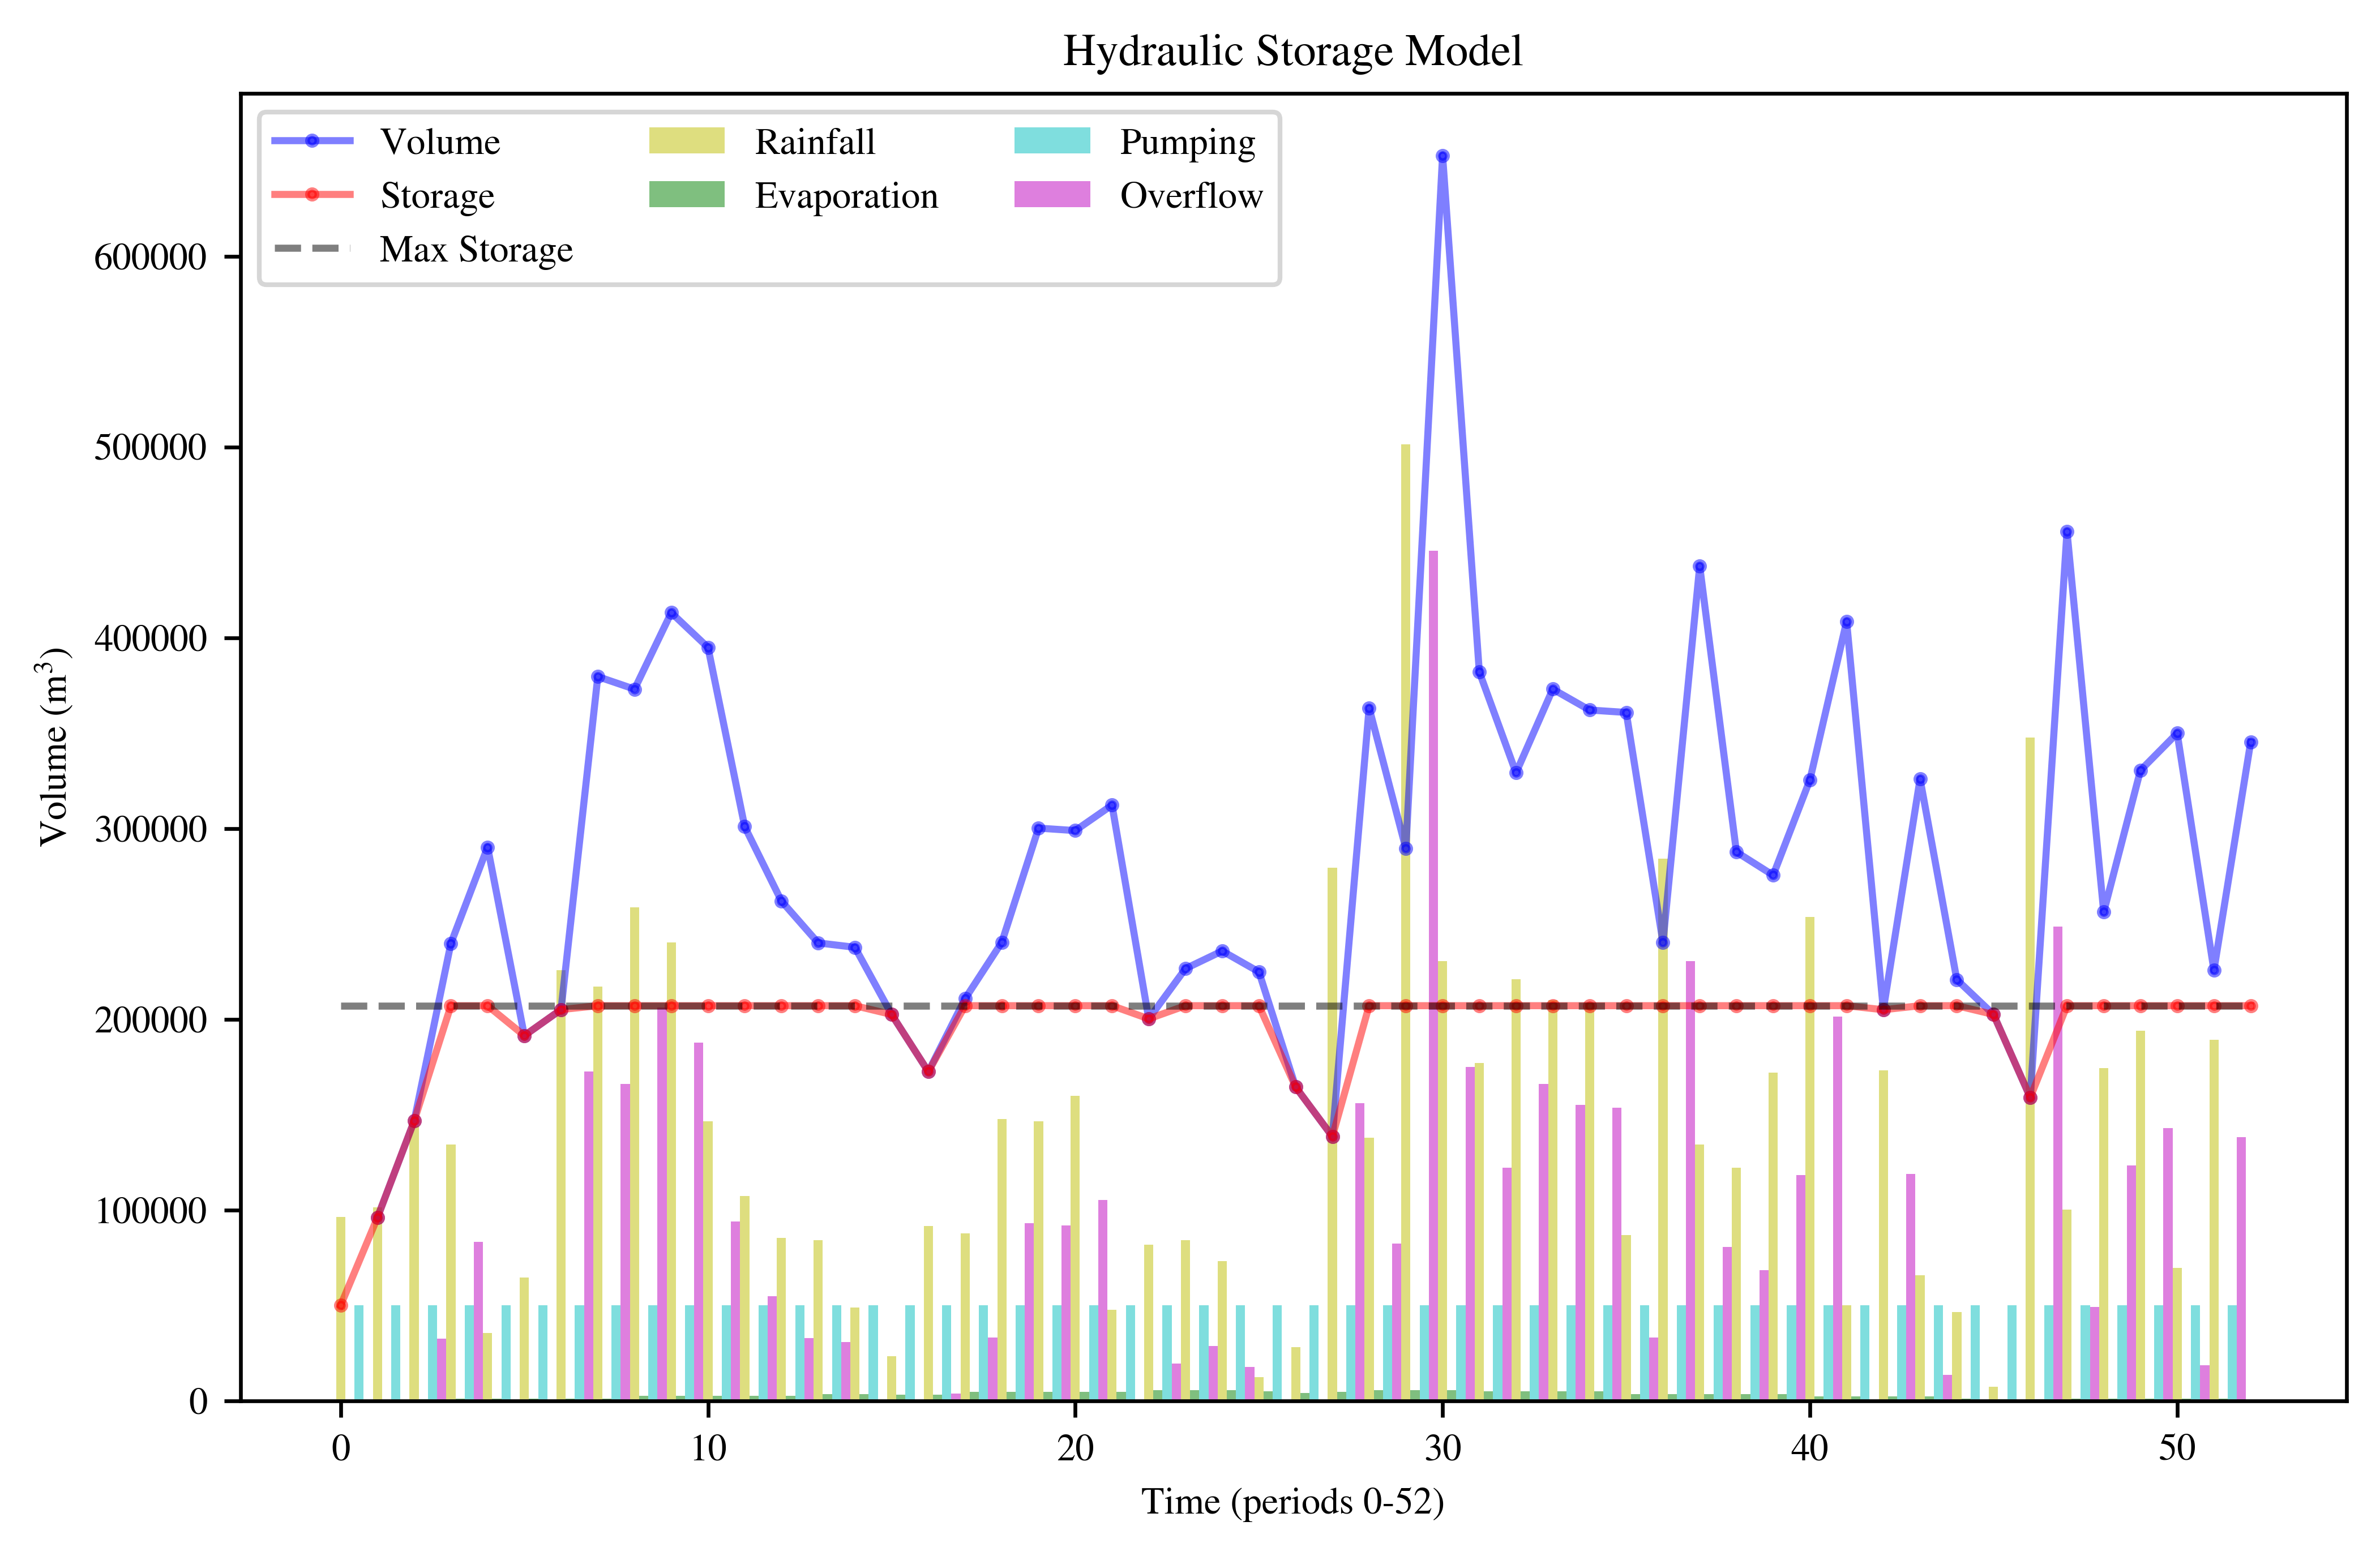

In [28]:
from dynamics_modeling import reservoir

model = reservoir.init(
    PRECIP, EVAP_RATE, MAX_VOLUME, MAX_AREA, MAX_PUMP_RATE, area_to_volume
)
SOLVER.solve(model)
plot_model(model)

# Archive

We used to use an abstract model (implementation is inconsistent to the above concrete model).


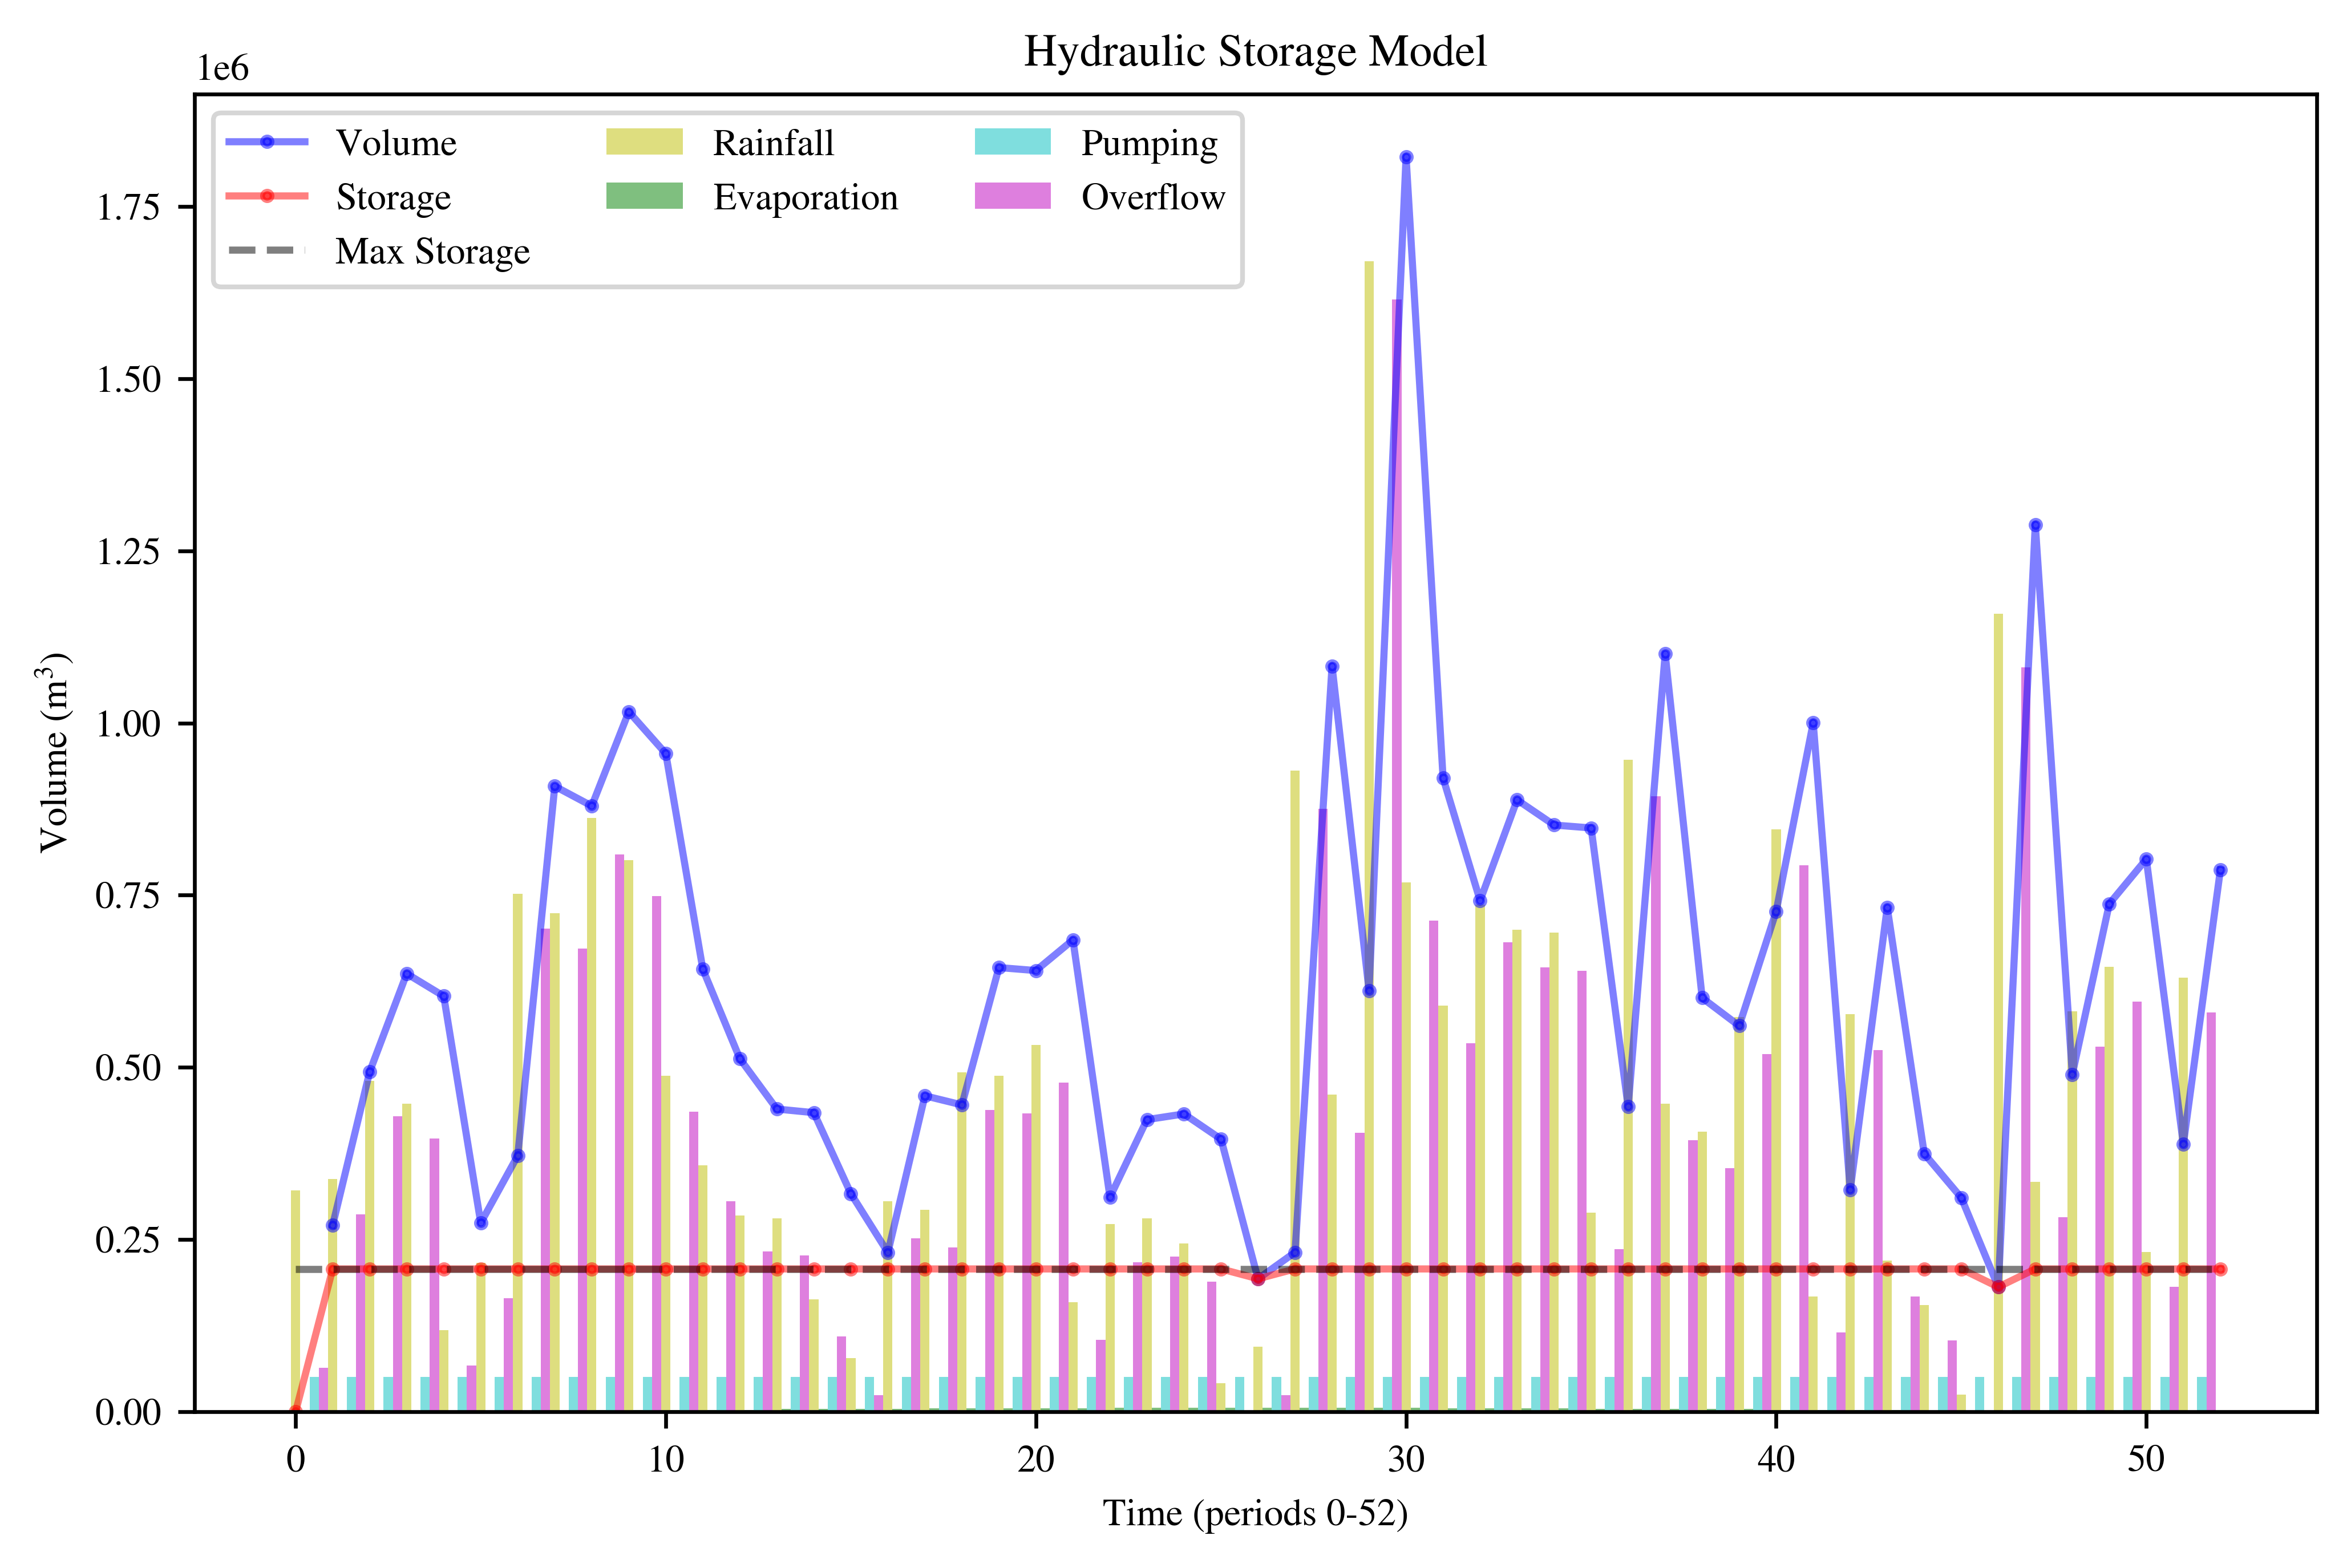

In [29]:
from dynamics_modeling import abstract_reservoir

model = abstract_reservoir.ReservoirModel(
    solver=abstract_reservoir.Solver(),
    g1=GAMMA_1,
    g2=GAMMA_2,
    catchment_area=CATCHMENT_AREA,
    max_area=MAX_AREA,
    precip_rate=PRECIP_RATE,
    pan_evap_rate=weekly_evap / PAN_COEFF,
    max_pump_rate=MAX_PUMP_RATE,
)

model.solve()
model.plot()